## Imports

In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# encoding imports
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# evaluation imports
from sklearn import metrics
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

# modeling imports
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor, BaggingRegressor, GradientBoostingRegressor 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR

# imbalanced modeling
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

---

## Overview

For this project, we are exploring two types of models, classification and regression. We going to see if we create a model that will predict the loss_percentage given a country while also identifying accurately which food stage is highly associated with food loss. 

The models we explored include:

---

### Importing Data

* Note: Set a random seed to make sure that when we re-run the models that we get the same training and testing set used.

In [5]:
np.random.seed(42)

In [6]:
df = pd.read_csv('./data/clean_data.csv')
df.head()

,Latitude,Longitude,country,commodity,year,loss_percentage,activity,food_supply_stage
0,33.0,65.0,Afghanistan,Wheat,2017,15.00,wsc,Whole supply chain
1,33.0,65.0,Afghanistan,Maize (corn),2017,14.95,wsc,Whole supply chain
2,33.0,65.0,Afghanistan,Rice,2017,7.09,wsc,Whole supply chain
3,33.0,65.0,Afghanistan,Barley,2017,14.74,wsc,Whole supply chain
4,33.0,65.0,Afghanistan,Wheat,2016,15.02,wsc,Whole supply chain


---

## Functions

Below are functions we will use throughout the notebook and their purpose.

### GridSearch Functions
* **best_params**: returns the best score and parameters for pipeline/model
* **return_gs**: returns the optimal parameters of a pipeline/model
* **tts_scores**: returns the Train and Test scores of a pipeline/model

In [7]:
def best_params(pipeline, params, X_train, y_train):
    gs = GridSearchCV(pipeline,
                      param_grid = params,
                      n_jobs=-1, 
                      cv = 3)

    gs.fit(X_train, y_train)
    
    return f'Best Score: {gs.best_score_}, Params: {gs.best_params_}'

In [8]:
def return_gs(pipeline, params, X_train, y_train):
    gs = GridSearchCV(pipeline,
                      param_grid = params,
                      n_jobs=-1, 
                      cv = 3)
    return gs

In [9]:
def tts_scores(gs, X_train, y_train, X_test, y_test):
    gs.fit(X_train, y_train)
    
    return f'Train Score: {gs.score(X_train, y_train)}, Test Score: {gs.score(X_test, y_test)}'

---

### Evaluation Functions

* **predictions**: accepts a pipeline and returns the predictions for y. In the instance of neural networks, the predictions are probabilities of the likelihood a datapoint is classified to a certain class.
* **regression_scores**: returns DataFrame of data for a model and its regression metric scores (R2, MSE, and RMSE)
* **classification_scores**: returns DataFrame of data fro a model and its classification metric scores (recall, precision, F1, accuracy)

In [10]:
def predictions(pipeline, X_train, X_test, y_train):
    pipeline.fit(X_train, y_train)
    prediction = pipeline.predict(X_test)
    
    return prediction

In [11]:
def regression_scores(model, y_test, y_pred):
    dataframe = pd.DataFrame(columns = ['R2', 'MSE', 'RMSE'])
    
    r2 = metrics.r2_score(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    dataframe.loc[model] = [r2, mse, rmse]
    
    pd.options.display.float_format = '{:.4f}'.format 
    
    return dataframe

In [12]:
def classification_scores(model, y_test, y_pred):
    dataframe = pd.DataFrame(columns = ['Recall', 'Precision', 'F1', 'Accuracy'])
    
    recall = recall_score(y_test, y_pred, average = 'micro')
    precision = precision_score(y_test, y_pred, average = 'micro')
    f1 = f1_score(y_test, y_pred, average = 'micro')
    accuracy = accuracy_score(y_test, y_pred)
    
    dataframe.loc[model] = [recall, precision, f1, accuracy]
    
    return dataframe

---

## Regression Models

Using our dataset, we are designing a series of regression models to accurately esimate the percentage of food loss across various nations. 

**Regression Models**:
* Random Forest Regressor
* Decision Tree Regressor
* Stacking
* Gradient Boost

**Metrics**: R2, MSE, RMSE

To encode our categorical columns, we chose to create dummy variables

We evaluated multiple classification models: Random Forest Classifer, Decision Tree Classifier, and Neural Network, and assessed their accuracy and F1 scores. To encode the categorical variable (food_supply_stage), we explored using a Label Encoder and dummy variables. The Label Encoder assigned a numerical value to each category (e.g. Farm may be instantiated to 0, etc.) even though they do not have an apparent order or rank. This enables the model to process data that requires numerical inputs. Dummy variables creates binary columns for the categories which ensure indepedence from one another. Although, with the amount of columns we'd create dummy variables for, it may introduce the curse of dimensionality with the increase in data size.


The regression models we explored were: Random Forest Regressor, Decision Tree Regressor, Stacking, and Gradient Boost. The metrics we used to evaluate our models were the R2, MSE, and RMSE scores. With a low RMSE, we'd want to have the lowest error to show that the regression model is performing well.

* Note: We encoded year as a dummy variable as it being an integer may have the model believe it has numerical value to the data

In [174]:
df_dummy = pd.get_dummies(df, columns = ['country',
                                         'commodity', 
                                         'year',
                                         'activity',
                                         'food_supply_stage'])

In [175]:
X = df_dummy.drop(columns = 'loss_percentage')
y = df_dummy['loss_percentage']

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

---

### Baseline Accuracy

The baseline accuracy takes the 'mean' of loss_percentage.

In [250]:
def bl_compare(model, pred):
    dataframe = pd.DataFrame(columns = ['Mean'])
    
    pipe_mean = np.mean(pred)
    
    dataframe.loc[model] = [pipe_mean]

    return dataframe

In [112]:
bl_mean = np.mean(y_train)

In [113]:
bl_pred = np.full_like(y_test, bl_mean)

In [114]:
regression_scores('Baseline', y_test, bl_pred)

,R2,MSE,RMSE
Baseline,-0.0001,26.7990,5.1768


In [115]:
bl_compare('Baseline', bl_pred)

,Mean
Baseline,3.9391


---

### Random Forest Regressor

Random Forest Regressor is a an ensemble learning model that aggregates multiple Decision Trees to make predictions. It randomly selects a subset of variables for these Decision Trees before averaging out the results to make one ultimate prediction. One of the advantages of Random Forest is its ability to highlight the strongest predictors in our model whilst considering the minority classes. 

When applying this model, we hypertuned n_estimators, max_depth, and min_samples_leaf for the best performance. The n_estimator determines the number of trees in the forest; max_depth controls the number of splits that a tree has; and min_samples_leaf is the minimum number of samples in a leaf node. We especially focused on hypertuning in a way that would advance the minority classes as our data is heavily imbalanced among different columns (e.g. country, activity, commodity). Random Forest does reduce overfitting compared to Decision Tree too.

**Evaluation**: Random Forest performed the best among all our regression models. Approximately 71.47% of the variability could be explained by our features selected. It is important to note that this model is extremely overfit between train and test scores(by over 20%), so it may not receive new data well.

In [177]:
rfr_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('rfr', RandomForestRegressor())
])

In [178]:
rfr_params = {
    'ss__with_mean': [False, True],
    'ss__with_std': [False, True],
    'rfr__n_estimators': [100, 150, 200, 250],
    'rfr__max_depth': [None, 10,50,80],
    'rfr__min_samples_leaf': [1,3, 4, 5]
}

In [179]:
best_params(rfr_pipe, rfr_params, X_train, y_train)

"Best Score: 0.6675328082564227, Params: {'rfr__max_depth': None, 'rfr__min_samples_leaf': 1, 'rfr__n_estimators': 150, 'ss__with_mean': True, 'ss__with_std': True}"

In [180]:
rfr_gs = return_gs(rfr_pipe, rfr_params, X_train, y_train)

In [181]:
tts_scores(rfr_gs, X_train, y_train, X_test, y_test)

'Train Score: 0.9240433293368834, Test Score: 0.7147991787806673'

In [182]:
cross_val_score(rfr_pipe, X_train, y_train, cv=3).mean()

0.6641485265334489

In [183]:
rfr_pred = predictions(rfr_pipe, X_train, X_test, y_train)

In [184]:
regression_scores('RandomForest', y_test, rfr_pred)

,R2,MSE,RMSE
RandomForest,0.7174,7.5719,2.7517


In [253]:
bl_compare('RandomForest', rfr_pred)

,Mean
RandomForest,3.8419


### Decision Tree Regressor

[finished, add description]
readability

In [50]:
dtr_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('dtr', DecisionTreeRegressor())
])

In [51]:
dtr_params = {
    'ss__with_mean': [False, True],
    'ss__with_std': [False, True],
    'dtr__max_depth': [9, 10,13,15],
    'dtr__min_samples_split': [15, 18,20],
    'dtr__min_samples_leaf': [1, 3, 5]
}

In [52]:
best_params(dtr_pipe, dtr_params, X_train, y_train)

"Best Score: 0.5147373797899001, Params: {'dtr__max_depth': 15, 'dtr__min_samples_leaf': 1, 'dtr__min_samples_split': 15, 'ss__with_mean': True, 'ss__with_std': False}"

In [53]:
dtr_gs = return_gs(dtr_pipe, dtr_params, X_train, y_train)

In [54]:
tts_scores(dtr_gs, X_train, y_train, X_test, y_test)

'Train Score: 0.6928624378266306, Test Score: 0.5704785376327788'

In [55]:
cross_val_score(dtr_pipe, X_train, y_train, cv=3).mean()

0.5511820606894577

In [56]:
dtr_pred = predictions(dtr_pipe, X_train, X_test, y_train)

In [57]:
regression_scores('DecisionTree', y_test, dtr_pred)

,R2,MSE,RMSE
DecisionTree,0.6063,10.5502,3.2481


In [116]:
bl_compare('DecisionTree', dtr_pred)

,Mean
DecisionTree,3.8507


### Stacking (Regression)

Stacking generates predictions from other models as features and pushes them through another model. In doing so, it could the the "best" performances and use that in making a great predictive model. As Random Forest Regressor 

In [61]:
level1_estimators =[
    ('rfr_pipe', Pipeline([
        ('ss', StandardScaler()),
        ('rfr', RandomForestRegressor())
    ])), 
    ('dt_pipe', Pipeline([
        ('ss', StandardScaler()),
        ('dt', DecisionTreeRegressor())
    ])),  
    ('bag_pipe', Pipeline([
        ('ss', StandardScaler()),
        ('bag', BaggingRegressor())
    ])),       
]

In [62]:
stacked_model = StackingRegressor(estimators = level1_estimators,
                                 final_estimator = LinearRegression())

In [63]:
cross_val_score(stacked_model, X_train, y_train).mean()

0.6619324829246788

In [64]:
stacked_model.fit(X_train, y_train)

StackingRegressor(estimators=[('rfr_pipe',
                               Pipeline(steps=[('ss', StandardScaler()),
                                               ('rfr',
                                                RandomForestRegressor())])),
                              ('dt_pipe',
                               Pipeline(steps=[('ss', StandardScaler()),
                                               ('dt',
                                                DecisionTreeRegressor())])),
                              ('bag_pipe',
                               Pipeline(steps=[('ss', StandardScaler()),
                                               ('bag', BaggingRegressor())]))],
                  final_estimator=LinearRegression())

In [65]:
stacked_model.score(X_train, y_train), stacked_model.score(X_test, y_test)

(0.9215573741286196, 0.7153878067192359)

In [66]:
stacked_pred = predictions(stacked_model, X_train, X_test, y_train)

In [67]:
regression_scores('Stacking', y_test, stacked_pred)

,R2,MSE,RMSE
Stacking,0.7224,7.4384,2.7273


In [117]:
bl_compare('Stacking', stacked_pred)

,Mean
Stacking,3.9683


In [249]:
df['country'].value_counts()

49     1178
32      885
58      879
116     787
120     728
       ... 
85        1
37        1
8         1
96        1
1         1
Name: country, Length: 122, dtype: int64

### Gradient Boosting

Gradient Boost will assess different models and build upon the weaker ones to minimize the prediction error. It's especially helpful in handling mixed datatypes (e.g. country) that have varying proportion in our data. The food_waste.csv didn't collect the same number of samples in different countries, so it suggests there may be sampling bias. 

**Evaluation**: Our Gradient Boost model performed the lowest explaining that approximately 48.74% of the variability in the 'loss_percentage' can be explained by the features in our model. Some reasons for this include underfitting, data quality, and insufficient data. 

In [118]:
gb_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('gb', GradientBoostingRegressor())
])

In [119]:
gb_params = {
    'ss__with_mean': [False, True],
    'ss__with_std': [False, True],
}

In [120]:
best_params(dtr_pipe, dtr_params, X_train, y_train)

"Best Score: 0.5135995306416755, Params: {'dtr__max_depth': 15, 'dtr__min_samples_leaf': 1, 'dtr__min_samples_split': 15, 'ss__with_mean': True, 'ss__with_std': False}"

In [121]:
dtr_gs = return_gs(dtr_pipe, dtr_params, X_train, y_train)

In [122]:
tts_scores(dtr_gs, X_train, y_train, X_test, y_test)

'Train Score: 0.6928624378266306, Test Score: 0.5948264402413468'

In [123]:
cross_val_score(gb_pipe, X_train, y_train, cv=3).mean()

0.4617622234122014

In [124]:
gb_pred = predictions(gb_pipe, X_train, X_test, y_train)

In [125]:
regression_scores('GradientBoost', y_test, gb_pred)

,R2,MSE,RMSE
GradientBoost,0.4874,13.7363,3.7063


In [126]:
bl_compare('GradientBoost', gb_pred)

,Mean
GradientBoost,3.8992


### Support Vector Regressor

While exploring models, we attempted a Linear Regression (not shown), and noticed that all the tests had poor results. This suggested that there likely was not a linear relationship between the variables. Thus, we looked at doing a Support Vector Regressor as its able to use different kernal functions (linear, polynomial) to reflect certain relationships in the data. SVR works on finding the closest match of a data point to the curve its created. The model is not recommended for large datasets since its susceptible to noise, so we ran a cross-validation score before hypertuning. 

**Evaluation**: The SVR explains about 28.19% of the variability in our target variable's R2 score, but since it's so low, we decided not to look further.

In [127]:
svr_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('svr', SVR(kernel = 'rbf'))
])

In [128]:
cross_val_score(svr_pipe, X_train, y_train, cv=3).mean()

0.2819942304995868

## Regression Model DataFrame

In [129]:
# Stacking
reg_table = regression_scores('Stacking', y_test, stacked_pred)

In [130]:
# Decision Tree
reg_table = pd.concat([reg_table, regression_scores('DecisionTree', y_test, dtr_pred)])

In [131]:
# Gradient Boosting
reg_table = pd.concat([reg_table, regression_scores('GradientBoost', y_test, gb_pred)])

In [185]:
# Random Forest
reg_table = pd.concat([reg_table, regression_scores('RandomForest', y_test, rfr_pred)])

In [191]:
reg_table.sort_values('R2', ascending = False)

,R2,MSE,RMSE
Stacking,0.7224,7.4384,2.7273
RandomForest,0.7174,7.5719,2.7517
DecisionTree,0.6063,10.5502,3.2481
GradientBoost,0.4874,13.7363,3.7063


---

## Classification Models

Within this dataset, producers documented their highest loss percentage of food and its corresponding food supply stage the loss occurred. There are approximately 17 stages identified and utilized to build a model that will accurately classify the stage for a datapoint's highest loss percentage. However, the classes are incredibly imbalanced; according to the baseline accuracy, 'Farm' appears in ~47% of the the data while the remaining 16 stages exist in less than 20% each. This aspect along with the large number of classes to classify may skew the classification model.

**Classification Models**:
* Random Forest Classifer
* Decision Tree Classifier
* Neural Network, 

**Metrics**: Accuracy and F1 scores. 

To encode the categorical variable (food_supply_stage), we explored using a Label Encoder and dummy variables. The Label Encoder assigned a numerical value to each category (e.g. Farm may be instantiated to 0, etc.) even though they do not have an apparent order or rank. This enables the model to process data that requires numerical inputs. Dummy variables creates binary columns for the categories which ensure indepedence from one another. Although, with the amount of columns we'd create dummy variables for, it may introduce the curse of dimensionality with the increase in data size.

Both methods resulted in similar scores and we made the conclusion that the encoding choices did not have a huge influence. 

### Baseline Accuracy

Below you will find the baseline accuracy of all 17 stages. Since the dataset is imbalanced, we will consider the F1 scores (and if needed, precision and recall) as the accuracy may not be fully representative. 

In [158]:
df['food_supply_stage'].value_counts(normalize = True)

Farm                 0.4701
Whole supply chain   0.1799
Harvest              0.1405
Storage              0.0989
Transport            0.0719
Wholesale            0.0096
Processing           0.0092
Retail               0.0089
Trader               0.0031
Households           0.0021
Export               0.0021
Post-harvest         0.0018
Food Services        0.0006
Pre-harvest          0.0004
Distribution         0.0004
Market               0.0004
Stacking             0.0000
Name: food_supply_stage, dtype: float64

### Random Forest Classifier

The Random Forest Classifier will generate decision trees based on randomly-selected columns and average the predictions. These actions will mitigate the impact of imbalanced classes and outliers through its likelihood in choosing data from minority classes. On the other hand, this model could also select low instances. One challenge that we could encounter is the time requirement to run this model as its making multiple predictions over a large dataset (> 20k).

In [310]:
# if there are missing values, use this for numerical columns by using the mean strategy
#for column in df.select_dtypes(include=[np.number]).columns:
    #imputer = SimpleImputer(strategy='mean')
    #df[column] = imputer.fit_transform(df[[column]])

In [192]:
# Using label encoder
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

* Train-Test-Split with Label Encoder

In [193]:
X = df.drop('food_supply_stage', axis=1)
y = df['food_supply_stage']

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [173]:
# create a Random Forest Classifier and fit it to the training data
rfc = RandomForestClassifier (n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [170]:
tts_scores(clf, X_train, y_train, X_test, y_test)

'Train Score: 0.998687526249475, Test Score: 0.9628307433851323'

In [171]:
rfc_pred = predictions(clf, X_train, X_test, y_train)

In [172]:
classification_scores('RandomForestClassifier', y_test, rfc_pred)

,Recall,Precision,F1,Accuracy
RandomForestClassifier,0.9628,0.9628,0.9628,0.9628


### Confusion Matrices (Random Forest)

By using a confusion matrix, we can visualize the predictions results of a model. Below, there is a matrix for each food_supply_supply (that is encoded).

* [code source: multiple confusion matrices](https://stackoverflow.com/questions/61825227/plotting-multiple-confusion-matrix-side-by-side/)
* [code source: flatten axes](https://stackoverflow.com/questions/46862861/what-does-axes-flat-in-matplotlib-do/)
* [code source: thresh/color of boxes](https://stackoverflow.com/questions/57043260/how-change-the-color-of-boxes-in-confusion-matrix-using-sklearn/)

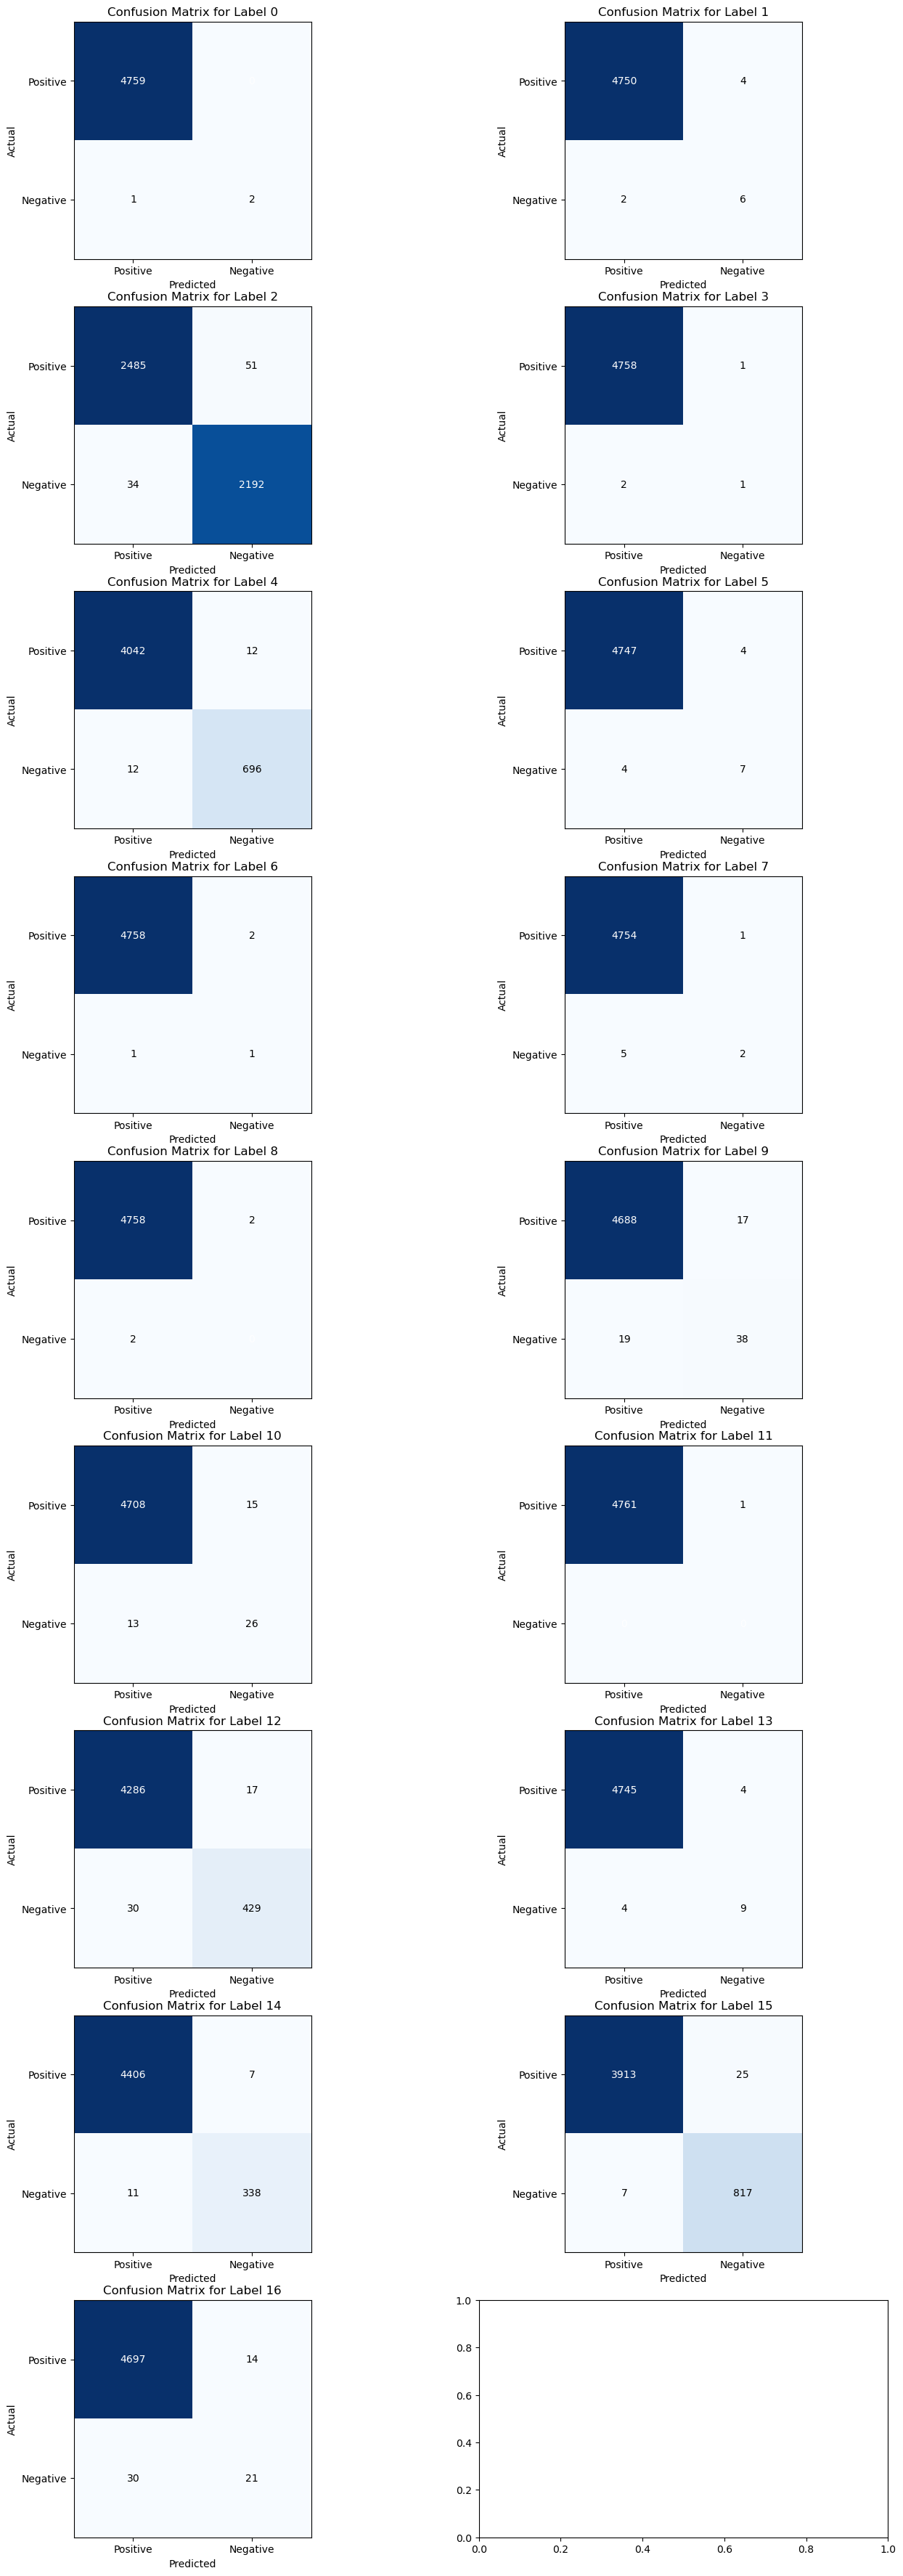

In [246]:
confusion_matrices = multilabel_confusion_matrix(y_test, rfc_pred)

# subplots
fig, axes = plt.subplots(9, 2, figsize=(16, 45))
axes = axes.flatten()

# iterate to display matrices
for i, cm in enumerate(confusion_matrices):
    ax = axes[i]
    ax.imshow(cm, cmap = plt.cm.Blues)
    ax.set_title(f"Confusion Matrix for Label {i}")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Positive', 'Negative'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Positive', 'Negative'))

    # code source above
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j]),
                    ha="center", va="center",
                    color="white" if cm[i, j] == 0 or cm[i, j] > thresh else "black")  
plt.show()

### Decision Tree Classifier


However, it's important to note that the decision tree classifier can get overfit quickly as it improves the model through each split. 

One difficulty is that it'll continue


In [204]:
# Code if you wanted to one-hot code with dummy variables instead

# features = pd.get_dummies(df, columns = ['Longitude', 'Latitude','country','commodity','year','activity'])
# X = features.drop(columns = 'food_supply_stage')
# y = pd.get_dummies(df['food_supply_stage'], columns = ['food_supply_stage'])

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [196]:
dt_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('dt', DecisionTreeClassifier())
])

In [197]:
dt_params = {
    'ss__with_mean': [False, True],
    'ss__with_std': [False, True],
    'dt__max_depth': [1, 5, 10, 25, 100],
    'dt__min_samples_leaf': [1, 3, 6, 10],
    'dt__min_samples_split': [5, 10, 15, 20]
}

In [198]:
best_params(dt_pipe, dt_params, X_train, y_train)

/Users/lisaliang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


"Best Score: 0.9597857434303624, Params: {'dt__max_depth': 100, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 5, 'ss__with_mean': False, 'ss__with_std': True}"

In [199]:
dt_gs = return_gs(dt_pipe, dt_params, X_train, y_train)

In [200]:
tts_scores(dt_gs, X_train, y_train, X_test, y_test)

/Users/lisaliang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


'Train Score: 0.9872427551448971, Test Score: 0.9632507349853003'

In [201]:
dt_pred = predictions(dt_pipe, X_train, X_test, y_train)

In [202]:
classification_scores('DecisionTree', y_test, dt_pred)

,Recall,Precision,F1,Accuracy
DecisionTree,0.9641,0.9641,0.9641,0.9641


### Confusion Matrices (Decision Tree)
* Note: View cited links above

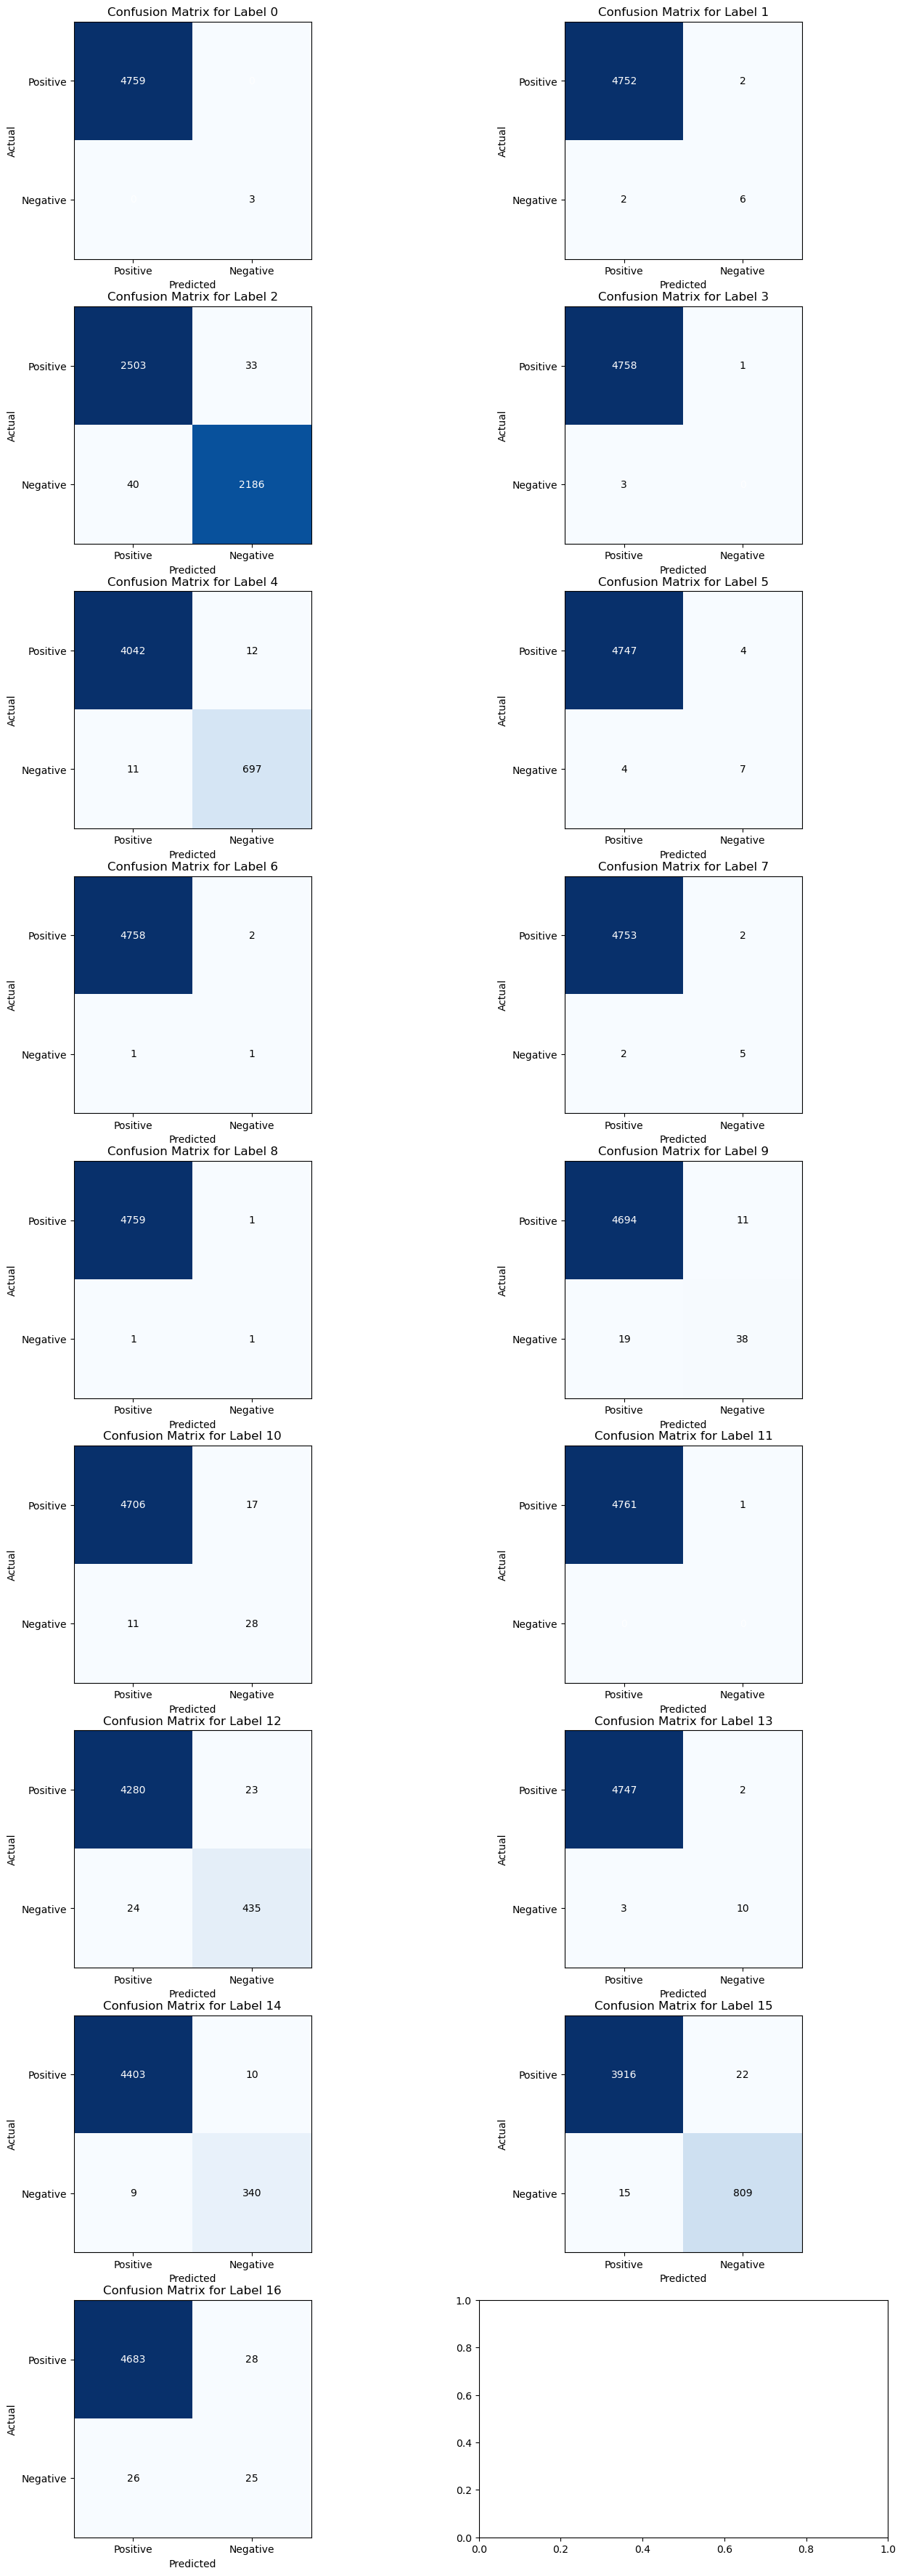

In [248]:
confusion_matrices = multilabel_confusion_matrix(y_test, dt_pred)

# subplots
fig, axes = plt.subplots(9, 2, figsize=(16, 45))
axes = axes.flatten()

# iterate to display matrices
for i, cm in enumerate(confusion_matrices):
    ax = axes[i]
    ax.imshow(cm, cmap = plt.cm.Blues)
    ax.set_title(f"Confusion Matrix for Label {i}")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Positive', 'Negative'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Positive', 'Negative'))

    # code source above
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j]),
                    ha="center", va="center",
                    color="white" if cm[i, j] == 0 or cm[i, j] > thresh else "black")  
plt.show()

### Classification Model DataFrame

Evaluation: Overall, Decision Tree 

In [205]:
class_model = classification_scores('RandomForestClassifier', y_test, rfc_pred)

In [206]:
class_model = pd.concat([class_model, classification_scores('DecisionTree', y_test, dt_pred)])

* Note: To view the work for NeuralNetwork, go to 'part2_extended_nn' as the work was done through Google Colab for ease of using Tensorflow there.

In [208]:
class_model.loc['NeuralNetwork'] = [0.924576, 0.914596, 0.917571, 0.924576]

In [252]:
class_model.sort_values('Accuracy', ascending = False)

,Recall,Precision,F1,Accuracy
DecisionTree,0.9641,0.9641,0.9641,0.9641
RandomForestClassifier,0.9628,0.9628,0.9628,0.9628
NeuralNetwork,0.9246,0.9146,0.9176,0.9246
